In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

In [ ]:
# List all visible GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Name:", gpu.name, "Type:", gpu.device_type)
else:
    print("No GPU devices found")

In [1]:
import gdown # to download dataset file from drive
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import random
import h5py

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import os
random.seed(0) # for validation

import time # measure training time

# Model archicture
import tensorflow as tf
import keras
from keras import backend as K

In [2]:
def convert_to_2d(arr, index=None):
    array = []
    if index != None:
        for subject_index in range(arr.shape[0]):
            array.extend(arr[subject_index][index])
    else:
        for subject_index in range(arr.shape[0]):
            array.extend(arr[subject_index])
    return np.array(array)

def find_max_min(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)

    return arr_min, arr_max

def to_timeseries(X, y, is_train, max_len):
    """
    generate data for one user.
    """
    seq_x = []
    seqs_x = []
    seqs_y = []
    seq_y = []

    min_max = np.load(data_path+'min_max.npy')
    min_max_train = np.load(data_path+'min_max_train.npy')

    ppg_all_min, ppg_all_max = min_max[0]
    ecg_all_min, ecg_all_max = min_max[1]
    abp_all_min, abp_all_max = min_max[2]

    ppg_train_min, ppg_train_max = min_max_train[0]
    ecg_train_min, ecg_train_max = min_max_train[1]
    abp_train_min, abp_train_max = min_max_train[2]

    for i in range(X[0].shape[0]):
        if len(seq_x) < max_len:
            if is_train:
                seq_x.append([
                    (X[0][i]-ppg_train_min)/(ppg_train_max-ppg_train_min),
                    (X[1][i]-ecg_train_min)/(ecg_train_max-ecg_train_min)
                ])
                seq_y.append([(y[i]-abp_train_min)/(abp_train_max-abp_train_min)])
            else:
                seq_x.append([
                    (X[0][i]-ppg_all_min)/(ppg_all_max-ppg_all_min),
                    (X[1][i]-ecg_all_min)/(ecg_all_max-ecg_all_min)
                ])
                seq_y.append([(y[i]-abp_all_min)/(abp_all_max-abp_all_min)])
        else:
            seq_x = seq_x[1:]
            seq_y = seq_y[1:]
            if is_train:
                seq_x.append([
                    (X[0][i]-ppg_train_min)/(ppg_train_max-ppg_train_min),
                    (X[1][i]-ecg_train_min)/(ecg_train_max-ecg_train_min)
                ])
                seq_y.append([(y[i]-abp_train_min)/(abp_train_max-abp_train_min)])
            else:
                seq_x.append([(X[0][i]-ppg_all_min)/(ppg_all_max-ppg_all_min), (X[1][i]-ecg_all_min)/(ecg_all_max-ecg_all_min)])
                seq_y.append([(y[i]-abp_all_min)/(abp_all_max-abp_all_min)])
        if len(seq_x) < max_len:
            continue
        else:
            seqs_x.append(seq_x)
            seqs_y.append(seq_y)

    zeros_y = np.zeros((len(seqs_y), max_len, 1))
    return seqs_x, zeros_y, seqs_y

def find_abp_peak_sys(abp, delay):
    index_max_abp = []
    loop_count = int(len(abp)/delay)
    index = 0
    for i in range(loop_count):
        max_value = 0
        max_index = 0
        for j in abp[i*delay:(i+1)*delay]:
            if j > max_value:
                max_value = j
                max_index = index

            index = index + 1
        index_max_abp.append(max_index)

    return index_max_abp

def find_abp_peak_dia(abp, delay):
    index_min_abp = []
    loop_count = int(len(abp)/delay)
    index = 0
    for i in range(loop_count):
        min_value = 9999999999
        min_index = 0
        for j in abp[i*delay:(i+1)*delay]:
            if j < min_value:
                min_value = j
                min_index = index
            index = index + 1

        index_min_abp.append(min_index)

    return index_min_abp

def zero_order_holding_first(abp, delay, is_sys):
    if is_sys:
        index_max_abp = find_abp_peak_sys(abp, delay)
    else:
        index_max_abp = find_abp_peak_dia(abp, delay)

    peak_abp = np.zeros(len(abp))
    j = 0
    for i in range(len(abp)):
        if i < index_max_abp[j]:
            if j == 1:
                peak_abp[i] = abp[index_max_abp[0]]
            else:
                peak_abp[i] = abp[index_max_abp[j-1]]
        else:
            j = j + 1
            if j >= len(index_max_abp):
                j = j - 1
            if j == 1:
                peak_abp[i] = abp[index_max_abp[0]]
            else:
                peak_abp[i] = abp[index_max_abp[j-1]]

    return peak_abp

def zero_order_second(signal):
    change = 0
    num = len(signal)
    for i in range(0, num-10):
        counter = 0
        if signal[i+1] != signal[i]:
            change = 1
            for j in range(1, 12):
                if signal[i+j] == signal[i]:
                    counter = counter + 1
        if change == 1 and counter > 0:
            for j in range(0, 11):
                signal[i+j] = signal[i]
        change = 0
    return signal

In [ ]:
file_id = "11w0fhkEe7MJq7JRoXmoJV8IHJQeGzdiC"
download_url = f"https://drive.google.com/uc?id={file_id}"
output_file = "part_1.mat"

gdown.download(download_url, output_file, quiet=False)

In [3]:
data_path = 'part_1.mat'

In [4]:
M = scipy.io.loadmat(data_path)['p'][0]

In [5]:
M.shape # 1000 3D arrays, (i.e. subjects with varying length of signals)

(1000,)

In [6]:
M = M[:200]

In [7]:
M.shape

(200,)

In [8]:
ex_ppg = M[0][0][0:400]
ex_ecg = M[0][2][0:400]
ex_abp = M[0][1][0:400]
     

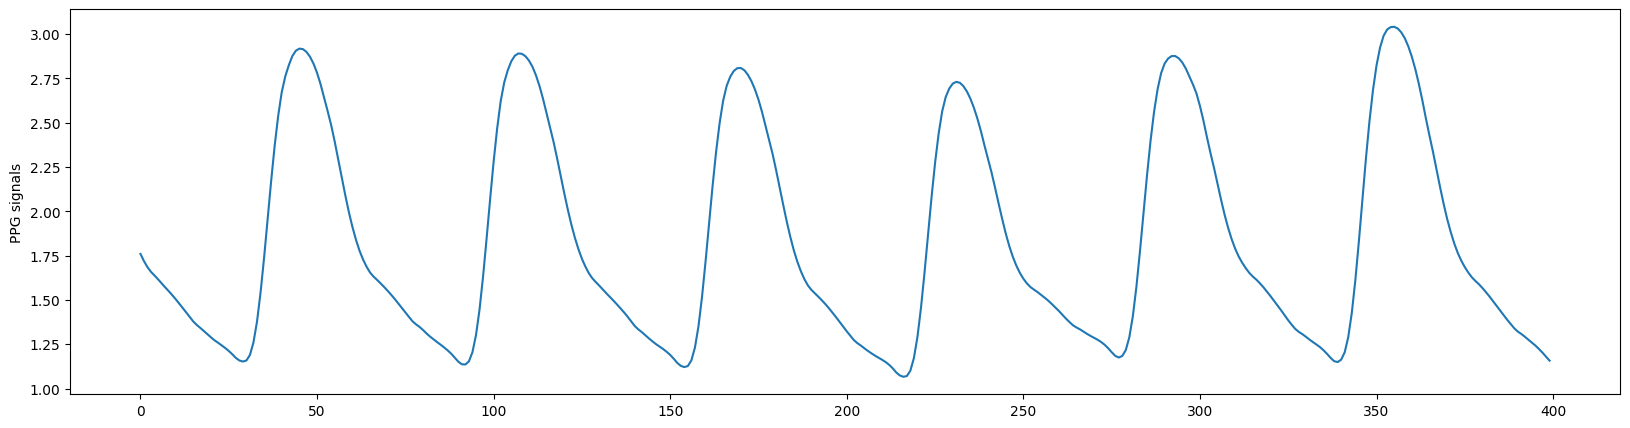

In [9]:
plt.figure(figsize=(20,5))
plt.plot(ex_ppg)
plt.ylabel('PPG signals')
plt.show()

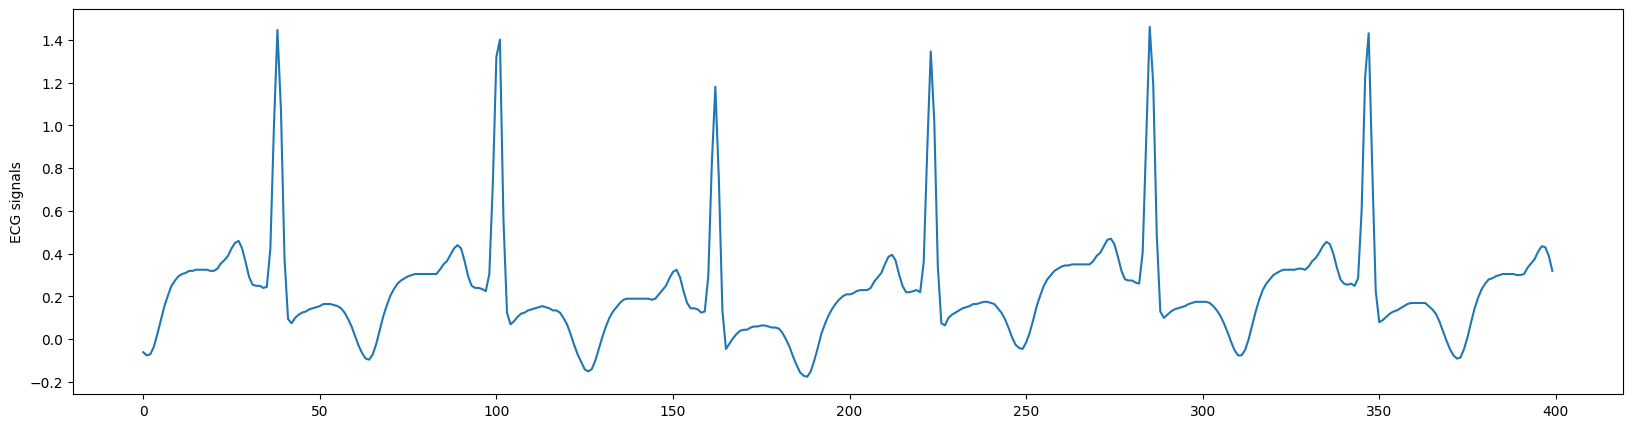

In [10]:
plt.figure(figsize=(20,5))
plt.plot(ex_ecg)
plt.ylabel('ECG signals')
plt.show()

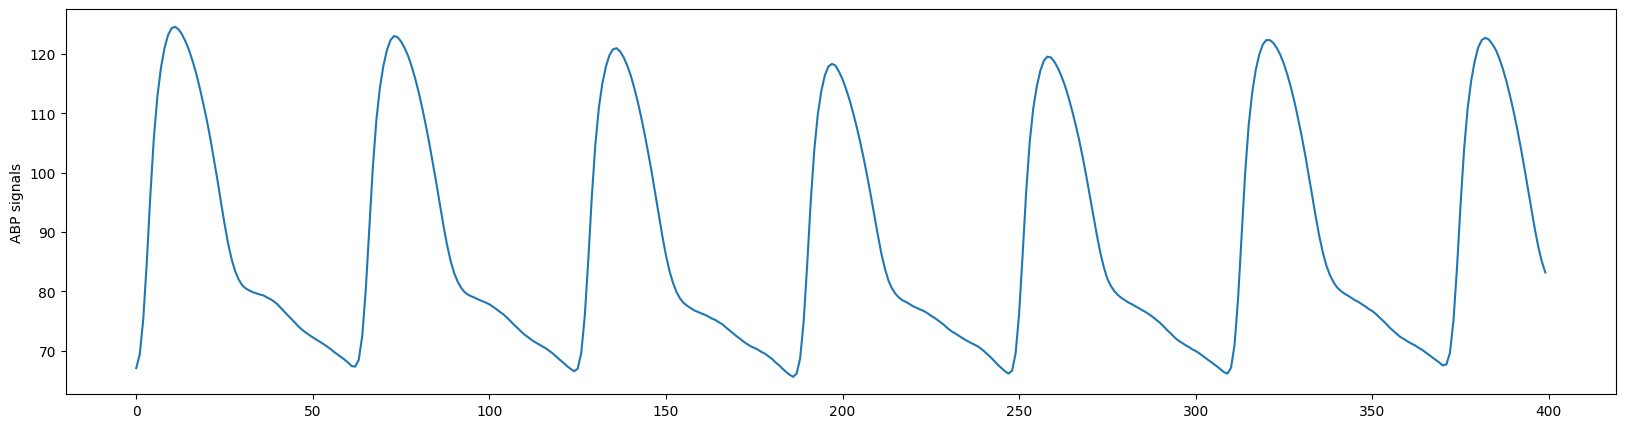

In [11]:
plt.figure(figsize=(20,5))
plt.plot(ex_abp)
plt.ylabel('ABP signals')
plt.show()

In [12]:
# PPG + ECG singals -> np.array
ppg_ecg = np.array([[M[index][0], M[index][2]] for index in range(M.shape[0])], dtype="object")
ppg_ecg.shape

(200, 2)

In [13]:
abp = np.array([M[index][1] for index in range(M.shape[0])], dtype="object")
abp.shape

(200,)

In [14]:
train_per = int(abp.shape[0] * 80 / 100)
test_per = abp.shape[0] - train_per  # Remaining 20% for testing

print('Num training set:', train_per)
print('Num testing set:', test_per)
     

Num training set: 160
Num testing set: 40


In [15]:
# sort data so, we will be able to train on the larger dataset
sort_index = np.argsort([value.shape[0] for value in abp])

ppg_ecg = np.array([ppg_ecg[index] for index in sort_index])
abp = np.array([abp[index] for index in sort_index], dtype="object")

In [16]:
X_main, X_test, y_main, y_test = ppg_ecg[test_per:], ppg_ecg[:test_per], abp[test_per:], abp[:test_per]

In [17]:
!mkdir data

A subdirectory or file data already exists.


In [18]:
data_path = 'data/'
data_path

'data/'

In [19]:
# Saving arrays with allow_pickle=True
np.save(data_path + 'x_train.npy', X_main, allow_pickle=True)
np.save(data_path + 'y_train.npy', y_main, allow_pickle=True)
np.save(data_path + 'x_test.npy', X_test, allow_pickle=True)
np.save(data_path + 'y_test.npy', y_test, allow_pickle=True)

In [20]:
ppg_conv = convert_to_2d(M, 0)
ecg_conv = convert_to_2d(M, 2)
abp_conv = convert_to_2d(M, 1)

In [21]:
# Check the shapes of data
print(ppg_conv.shape)
print(ecg_conv.shape)
print(abp_conv.shape)

(6635000,)
(6635000,)
(6635000,)


In [22]:
ppg_all_min, ppg_all_max = find_max_min(ppg_conv)
ecg_all_min, ecg_all_max = find_max_min(ecg_conv)
abp_all_min, abp_all_max = find_max_min(abp_conv)

In [23]:
print("PPG_min ", ppg_all_min)
print("PPG_max ", ppg_all_max)
print("ECG_min ", ecg_all_min)
print("ECG_max ", ecg_all_max)
print("ABP_min ", abp_all_min)
print("ABP_max ", abp_all_max)

PPG_min  0.0
PPG_max  4.001955034213099
ECG_min  -0.5004887585532747
ECG_max  1.5009775171065494
ABP_min  50.01623903864891
ABP_max  199.69404082972375


In [24]:
np.save(data_path+'min_max.npy', np.array([
    [ppg_all_min, ppg_all_max],
    [ecg_all_min, ecg_all_max],
    [abp_all_min, abp_all_max]
]), allow_pickle=True)

In [25]:
X_train = np.load(data_path+'x_train.npy', allow_pickle=True)
y_train = np.load(data_path+'y_train.npy', allow_pickle=True)
X_test = np.load(data_path+'x_test.npy', allow_pickle=True)
y_test = np.load(data_path+'y_test.npy', allow_pickle=True)


In [26]:
# Check the shape of data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(160, 2)
(160,)
(40, 2)
(40,)


In [27]:
min_max = np.load(data_path+'min_max.npy', allow_pickle=True)
ppg_all_min, ppg_all_max = min_max[0]
ecg_all_min, ecg_all_max = min_max[1]
abp_all_min, abp_all_max = min_max[2]

In [28]:
ppg_train_conv = convert_to_2d(X_train, 0)
ecg_train_conv = convert_to_2d(X_train, 1)
abp_train_conv = convert_to_2d(y_train)

In [29]:
# Check shapes
print(ppg_train_conv.shape)
print(ecg_train_conv.shape)
print(abp_train_conv.shape)

(6575000,)
(6575000,)
(6575000,)


In [30]:
ppg_train_min, ppg_train_max = find_max_min(ppg_train_conv)
ecg_train_min, ecg_train_max = find_max_min(ecg_train_conv)
abp_train_min, abp_train_max = find_max_min(abp_train_conv)
     

In [31]:
np.save(data_path+'min_max_train.npy', np.array([
    [ppg_train_min, ppg_train_max],
    [ecg_train_min, ecg_train_max],
    [abp_train_min, abp_train_max]
]))

In [38]:
batch_size = 1024
epochs = 10
timewindow = 32
     

In [33]:
# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_main, y_main, test_size=0.2, random_state=42)

# Convert the training set to time series
encoder_input, decoder_output, decoder_input = [], [], []
print('Start converting training set to timeseries...')
for i in range(X_train.shape[0]):
    s_x, z_y, s_y = to_timeseries(X_train[i], y_train[i], is_train=True, max_len=timewindow)
    encoder_input.extend(s_x)
    decoder_output.extend(s_y)
    decoder_input.extend(z_y)
encoder_input, decoder_output, decoder_input = map(np.array, [encoder_input, decoder_output, decoder_input])
print('Done converting training set to timeseries...')
print('Num of sequences:', encoder_input.shape[0])
print('-' * 30)

# Convert the validation set to time series
encoder_input_valid, decoder_output_valid, decoder_input_valid = [], [], []
print('Start converting validation set to timeseries...')
for i in range(X_valid.shape[0]):
    s_x, z_y, s_y = to_timeseries(X_valid[i], y_valid[i], is_train=False, max_len=timewindow)
    encoder_input_valid.extend(s_x)
    decoder_output_valid.extend(s_y)
    decoder_input_valid.extend(z_y)
encoder_input_valid, decoder_output_valid, decoder_input_valid = map(np.array, [encoder_input_valid, decoder_output_valid, decoder_input_valid])
print('Done converting validation set to timeseries...')
print('Num of sequences:', encoder_input_valid.shape[0])
print('=' * 30)
     

Start converting training set to timeseries...
Done converting training set to timeseries...
Num of sequences: 5288032
------------------------------
Start converting validation set to timeseries...
Done converting validation set to timeseries...
Num of sequences: 1282008


In [34]:
# Check shapes of encoder-decoder inputs/outputs
print(encoder_input.shape)
print(decoder_output.shape)

print(decoder_input.shape)
print(encoder_input_valid.shape)

print(decoder_output_valid.shape)
print(decoder_input_valid.shape)

(5288032, 32, 2)
(5288032, 32, 1)
(5288032, 32, 1)
(1282008, 32, 2)
(1282008, 32, 1)
(1282008, 32, 1)


In [35]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def create_model():

    keras.backend.clear_session()

    layers = [128, 128]  # Number of hidden neurons in each layer of the encoder and decoder

    optimiser = keras.optimizers.Adam(learning_rate=0.001)  # No decay parameter

    num_input_features = 2  # The dimensionality of the input at each time step. In this case a 1D signal.
    num_output_features = 1  # The dimensionality of the output at each time step. In this case a 1D signal.

    loss = rmse  # Root Mean Squared Error loss function

    lambda_regulariser = 0.000001  # Regularization parameter
    regulariser = None  # No regularization used in this example

    # Define the encoder input layer
    encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

    # Create LSTM cells for the encoder
    encoder_cells = []
    for hidden_neurons in layers:
        encoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                                  kernel_regularizer=regulariser,
                                                  recurrent_regularizer=regulariser,
                                                  bias_regularizer=regulariser))

    # Create the encoder RNN layer
    encoder = keras.layers.RNN(encoder_cells, return_state=True)

    # Get encoder outputs and states
    encoder_outputs_and_states = encoder(encoder_inputs)

    # Keep only the states, discard the encoder outputs
    encoder_states = encoder_outputs_and_states[1:]

    # Define the decoder input layer
    decoder_inputs = keras.layers.Input(shape=(None, 1))

    # Create LSTM cells for the decoder
    decoder_cells = []
    for hidden_neurons in layers:
        decoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                                  kernel_regularizer=regulariser,
                                                  recurrent_regularizer=regulariser,
                                                  bias_regularizer=regulariser))

    # Create the decoder RNN layer
    decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

    # Set the initial state of the decoder to be the output state of the encoder
    decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

    # Only select the decoder outputs (not the states)
    decoder_outputs = decoder_outputs_and_states[0]

    # Apply a dense layer with linear activation to set output to correct dimension
    decoder_dense = keras.layers.Dense(num_output_features,
                                       activation='linear',
                                       kernel_regularizer=regulariser,
                                       bias_regularizer=regulariser)

    # Final output of the model
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the Keras model
    model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

    # Compile the model with Adam optimizer and RMSE loss
    model.compile(optimizer=optimiser, loss=loss, metrics=['mae'])

    return model

In [39]:
# Create and train the model
model = create_model()
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

start_time = time.time()
history = model.fit(
    [encoder_input, decoder_input], decoder_output,
    validation_data=([encoder_input_valid, decoder_input_valid], decoder_output_valid),
    batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1, callbacks=callbacks
)
end_time = time.time()
training_duration = end_time - start_time

hours, rem = divmod(training_duration, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Training duration: {training_duration} seconds")
print(f"Training duration: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")


Epoch 1/10
5165/5165 [==============================] - 866s 167ms/step - loss: 0.0839 - mae: 0.0593 - val_loss: 0.0746 - val_mae: 0.0591
Epoch 2/10
5165/5165 [==============================] - 875s 169ms/step - loss: 0.0546 - mae: 0.0359 - val_loss: 0.0728 - val_mae: 0.0575
Epoch 3/10
5165/5165 [==============================] - 885s 171ms/step - loss: 0.0492 - mae: 0.0320 - val_loss: 0.0680 - val_mae: 0.0536
Epoch 4/10
5165/5165 [==============================] - 813s 157ms/step - loss: 0.0457 - mae: 0.0296 - val_loss: 0.0695 - val_mae: 0.0548
Epoch 5/10
5165/5165 [==============================] - 798s 155ms/step - loss: 0.0436 - mae: 0.0281 - val_loss: 0.0699 - val_mae: 0.0554
Epoch 6/10
5165/5165 [==============================] - 792s 153ms/step - loss: 0.0417 - mae: 0.0268 - val_loss: 0.0698 - val_mae: 0.0547
Epoch 7/10
5165/5165 [==============================] - 795s 154ms/step - loss: 0.0404 - mae: 0.0259 - val_loss: 0.0683 - val_mae: 0.0539
Epoch 8/10
5165/5165 [============

In [40]:
!mkdir weights

In [41]:
model.save_weights('weights/model-weight1.h5')

In [42]:
model = create_model()
model.load_weights('weights/model-weight1.h5')
     

In [43]:
user_test = 0 #index of a subject
test_x, test_zeros, _ = to_timeseries(X_test[user_test], y_test[user_test], is_train=False, max_len=timewindow)
ground_truth_x, _, ground_truth_y = to_timeseries(X_test[user_test], y_test[user_test], is_train=False, max_len=timewindow)

     

In [44]:
y_test_predicted = model.predict([np.array(test_x), test_zeros],
                                batch_size=batch_size, verbose=1)

1/1 [==============================] - 0s 294ms/step


In [45]:
y_test_predicted_flat = y_test_predicted.flatten()
y_test_predicted_flat.shape

(31008,)

In [46]:
ground_truth_y_flat = np.array(ground_truth_y).flatten()
ground_truth_y_flat.shape
     

(31008,)

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming ground_truth_y is your actual test output and y_test_predicted is the predicted output
# Calculate MSE
mse = mean_squared_error(ground_truth_y_flat, y_test_predicted_flat)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(ground_truth_y_flat, y_test_predicted_flat)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R2 score
r2 = r2_score(ground_truth_y_flat, y_test_predicted_flat)
print(f"R-squared (R2 Score): {r2}")

Mean Squared Error (MSE): 0.03662069630611527
Root Mean Squared Error (RMSE): 0.1913653477150847
Mean Absolute Error (MAE): 0.14420412428112417
R-squared (R2 Score): -0.16182347640736428


In [48]:
pred_abp = []
gt_abp = []
for i in range(y_test_predicted.shape[0]):
    pred_abp.append(y_test_predicted[i][-1][0]*(abp_all_max-abp_all_min)+abp_all_min)
    gt_abp.append(ground_truth_y[i][-1][0]*(abp_all_max-abp_all_min)+abp_all_min)

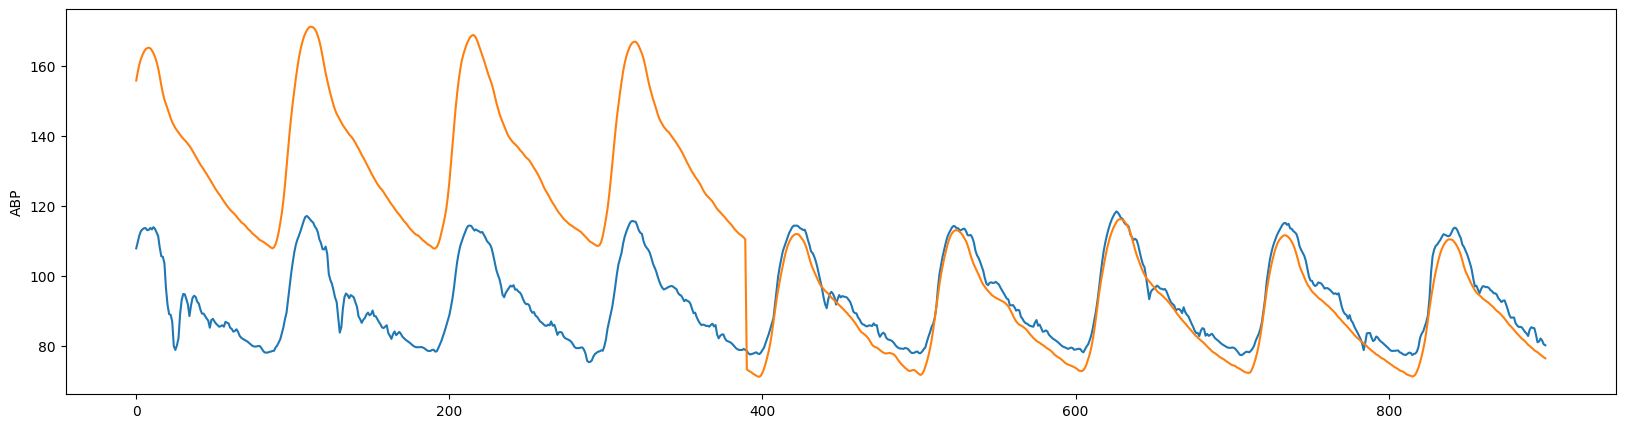

In [49]:
plt.figure(figsize=(20,5))
plt.plot(pred_abp[68:1000])
#plt.plot(pred_dia)
plt.plot(gt_abp[68:1000])
#plt.plot(gt_dia)
plt.ylabel('ABP')
plt.show()

In [50]:
pred_sys = zero_order_holding_first(pred_abp, delay=100, is_sys=True)
gt_sys = zero_order_holding_first(gt_abp, delay=100, is_sys=True)

pred_dia = zero_order_holding_first(pred_abp, delay=100, is_sys=False)
gt_dia = zero_order_holding_first(gt_abp, delay=100, is_sys=False)

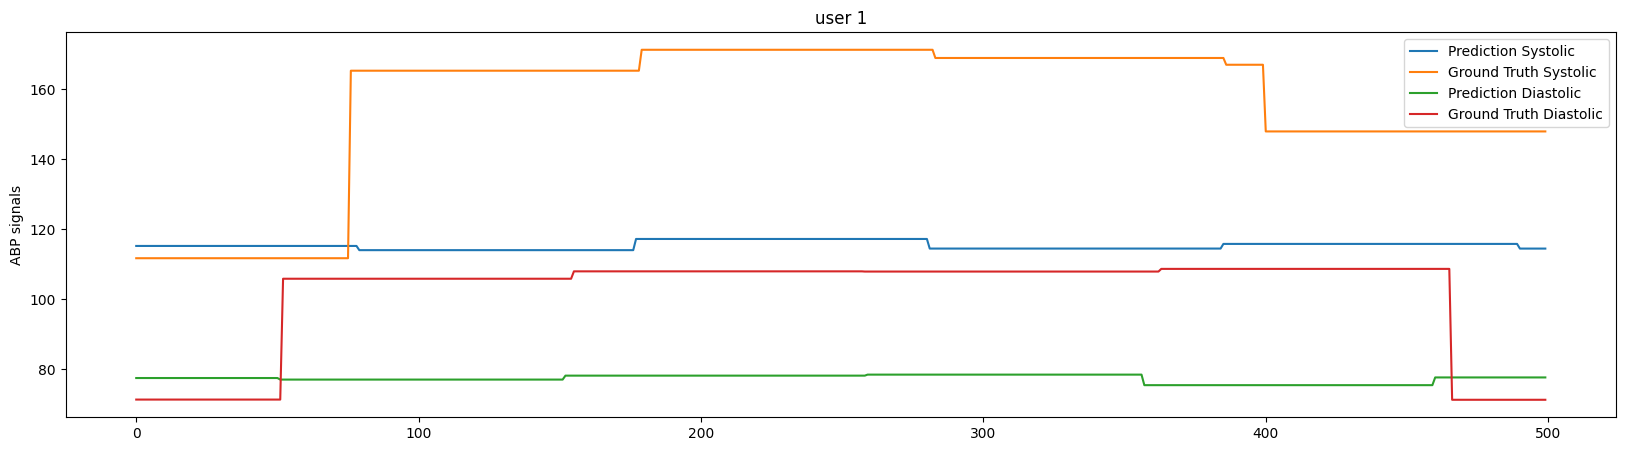

In [51]:
plt.figure(figsize=(20,5))
plt.plot(pred_sys[:500], label='Prediction Systolic')
plt.plot(gt_sys[:500], label='Ground Truth Systolic')
plt.plot(pred_dia[:500], label='Prediction Diastolic')
plt.plot(gt_dia[:500], label='Ground Truth Diastolic')
plt.ylabel('ABP signals')
plt.legend(loc='upper right')
plt.title('user ' + str(user_test+1))
plt.show()

In [52]:
pred_sys_ls = []
gt_sys_ls = []
pred_dia_ls = []
gt_dia_ls = []

rmse_sys_subjects = []
rmse_dia_subjects = []
mae_sys_subjects = []
mae_dia_subjects = []

for i in range(X_test.shape[0]):
    test_x, test_zeros, _ = to_timeseries(X_test[i], y_test[i], is_train=False, max_len=timewindow)
    ground_truth_x, _, ground_truth_y = to_timeseries(X_test[i], y_test[i], is_train=False, max_len=timewindow)
    y_test_predicted = model.predict([np.array(test_x), test_zeros],
                                     batch_size=batch_size)
    p_abp = []
    g_abp = []
    for j in range(y_test_predicted.shape[0]):
        p_abp.append(y_test_predicted[j][-1][0]*(abp_all_max-abp_all_min)+abp_all_min)
        g_abp.append(ground_truth_y[j][-1][0]*(abp_all_max-abp_all_min)+abp_all_min)


    p_sys = zero_order_holding_first(p_abp, delay=100, is_sys=True)
    g_sys = zero_order_holding_first(g_abp, delay=100, is_sys=True)
    p_dia = zero_order_holding_first(p_abp, delay=100, is_sys=False)
    g_dia = zero_order_holding_first(g_abp, delay=100, is_sys=False)


    p_sys = zero_order_second(p_sys)
    g_sys = zero_order_second(g_sys)
    p_dia = zero_order_second(p_dia)
    g_dia = zero_order_second(g_dia)

    pred_sys_ls.extend(p_sys)
    gt_sys_ls.extend(g_sys)
    pred_dia_ls.extend(p_dia)
    gt_dia_ls.extend(g_dia)

    rmse_sys_all = sqrt(mean_squared_error(gt_sys_ls, pred_sys_ls))
    rmse_dia_all = sqrt(mean_squared_error(gt_dia_ls, pred_dia_ls))
    mae_sys_all = mean_absolute_error(gt_sys_ls, pred_sys_ls)
    mae_dia_all = mean_absolute_error(gt_dia_ls, pred_dia_ls)

    rmse_sys_subjects.append(sqrt(mean_squared_error(g_sys, p_sys)))
    rmse_dia_subjects.append(sqrt(mean_squared_error(g_dia, p_dia)))
    mae_sys_subjects.append(mean_absolute_error(g_sys, p_sys))
    mae_dia_subjects.append(mean_absolute_error(g_dia, p_dia))

3/3 [==============================] - 0s 37ms/step


In [53]:
print('Overall RMSE Systolic: %.3f (mmHg)' % rmse_sys_all)
print('Overall RMSE Diastolic: %.3f (mmHg)' % rmse_dia_all)


print('Overall MAE Systolic: %.3f (mmHg)' % mae_sys_all)
print('Overall MAE Diastolic: %.3f (mmHg)' % mae_dia_all)

Overall RMSE Systolic: 21.013 (mmHg)
Overall RMSE Diastolic: 16.120 (mmHg)
Overall MAE Systolic: 13.671 (mmHg)
Overall MAE Diastolic: 7.768 (mmHg)


In [54]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

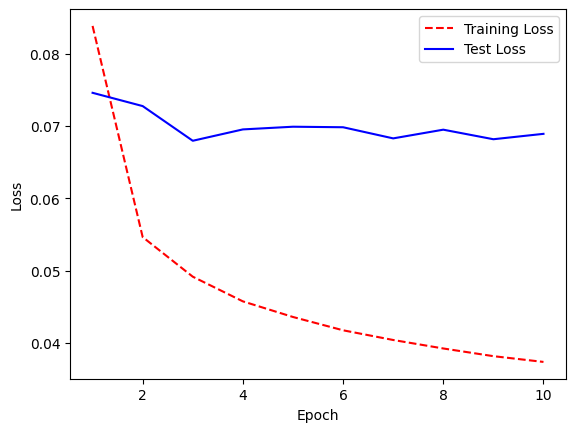

In [55]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();